In [2]:
# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.16.1
Keras version: 3.12.0


In [3]:
# Load dataset
data = np.load('dataset_dev_3000.npz')
X = data['X']
y = data['y']

print(f"Input X shape: {X.shape}")
print(f"Targets y shape: {y.shape}")
print(f"\nTarget A (10-class): range [{y[:, 0].min():.0f}, {y[:, 0].max():.0f}]")
print(f"Target B (32-class): {len(np.unique(y[:, 1]))} classes")
print(f"Target C (Regression): range [{y[:, 2].min():.4f}, {y[:, 2].max():.4f}]")

Input X shape: (3000, 32, 32)
Targets y shape: (3000, 3)

Target A (10-class): range [0, 9]
Target B (32-class): 32 classes
Target C (Regression): range [0.0003, 0.9996]


In [4]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y[:, 0]
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (2400, 32, 32)
Validation set: (600, 32, 32)


## Model 1: Single-Task Baseline CNN (Target A only)

In [5]:
def build_baseline_cnn():
    """Simple CNN for Target A (10-class classification)"""
    model = Sequential([
        Input(shape=(32, 32, 1)),
        Conv2D(32, 3, activation='relu', padding='same'),
        MaxPooling2D(2),
        Conv2D(64, 3, activation='relu', padding='same'),
        MaxPooling2D(2),
        Conv2D(64, 3, activation='relu', padding='same'),
        MaxPooling2D(2),
        layers.Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build and display
baseline_model = build_baseline_cnn()
# baseline_model.summary()

In [6]:
# Train baseline model
print("Training baseline model...")

callbacks_baseline = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history_baseline = baseline_model.fit(
    X_train, y_train[:, 0],
    validation_data=(X_val, y_val[:, 0]),
    epochs=50,
    batch_size=64,
    callbacks=callbacks_baseline,
    verbose=2
)

# Evaluate
val_loss, val_acc = baseline_model.evaluate(X_val, y_val[:, 0], verbose=2)
print(f"\n✓ Baseline Model - Validation Accuracy: {val_acc*100:.2f}%")

Training baseline model...
Epoch 1/50
38/38 - 2s - 41ms/step - accuracy: 0.1133 - loss: 2.3078 - val_accuracy: 0.1000 - val_loss: 2.2976 - learning_rate: 0.0010
Epoch 2/50
38/38 - 1s - 14ms/step - accuracy: 0.1183 - loss: 2.2942 - val_accuracy: 0.1383 - val_loss: 2.2898 - learning_rate: 0.0010
Epoch 3/50
38/38 - 1s - 14ms/step - accuracy: 0.1396 - loss: 2.2800 - val_accuracy: 0.1683 - val_loss: 2.2444 - learning_rate: 0.0010
Epoch 4/50
38/38 - 1s - 15ms/step - accuracy: 0.1488 - loss: 2.2499 - val_accuracy: 0.1583 - val_loss: 2.2202 - learning_rate: 0.0010
Epoch 5/50
38/38 - 1s - 14ms/step - accuracy: 0.1621 - loss: 2.2326 - val_accuracy: 0.2000 - val_loss: 2.1807 - learning_rate: 0.0010
Epoch 6/50
38/38 - 1s - 14ms/step - accuracy: 0.1813 - loss: 2.1915 - val_accuracy: 0.2133 - val_loss: 2.1227 - learning_rate: 0.0010
Epoch 7/50
38/38 - 1s - 14ms/step - accuracy: 0.1863 - loss: 2.1464 - val_accuracy: 0.2517 - val_loss: 2.0605 - learning_rate: 0.0010
Epoch 8/50
38/38 - 1s - 14ms/step -

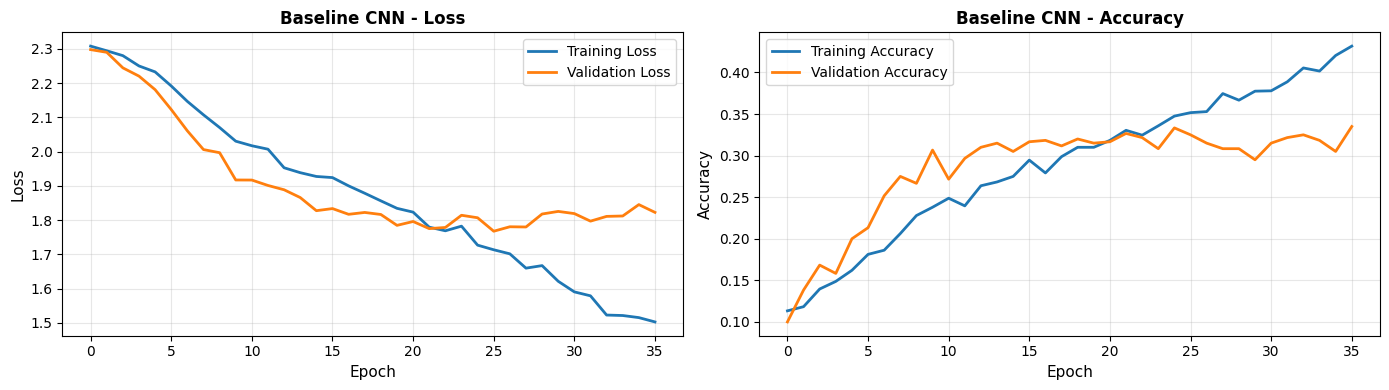

✓ Training completed in 36 epochs
  Best validation accuracy: 33.50%


In [7]:
# Plot training history for baseline model
def make_chart():
  fig, axes = plt.subplots(1, 2, figsize=(14, 4))

  # Plot loss
  axes[0].plot(history_baseline.history['loss'], label='Training Loss', linewidth=2)
  axes[0].plot(history_baseline.history['val_loss'], label='Validation Loss', linewidth=2)
  axes[0].set_xlabel('Epoch', fontsize=11)
  axes[0].set_ylabel('Loss', fontsize=11)
  axes[0].set_title('Baseline CNN - Loss', fontsize=12, fontweight='bold')
  axes[0].legend()
  axes[0].grid(True, alpha=0.3)

  # Plot accuracy
  axes[1].plot(history_baseline.history['accuracy'], label='Training Accuracy', linewidth=2)
  axes[1].plot(history_baseline.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
  axes[1].set_xlabel('Epoch', fontsize=11)
  axes[1].set_ylabel('Accuracy', fontsize=11)
  axes[1].set_title('Baseline CNN - Accuracy', fontsize=12, fontweight='bold')
  axes[1].legend()
  axes[1].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

  print(f"✓ Training completed in {len(history_baseline.history['loss'])} epochs")
  print(f"  Best validation accuracy: {max(history_baseline.history['val_accuracy'])*100:.2f}%")

make_chart()

In [193]:
# Prepare data for multi-task training
X_train_mtl = X_train[..., None].astype('float32')
X_val_mtl = X_val[..., None].astype('float32')

# Normalize
mean = X_train_mtl.mean()
std = X_train_mtl.std() + 1e-6
X_train_mtl = (X_train_mtl - mean) / std
X_val_mtl = (X_val_mtl - mean) / std

# Extract targets
y_A_train, y_B_train, y_C_train = y_train[:, 0], y_train[:, 1], y_train[:, 2]
y_A_val, y_B_val, y_C_val = y_val[:, 0], y_val[:, 1], y_val[:, 2]

# print("Data prepared for multi-task learning:")
# print(f"  X_train: {X_train_mtl.shape}")
# print(f"  X_val: {X_val_mtl.shape}")
# print(f"  Target A: {y_A_train.shape} (10 classes)")
# print(f"  Target B: {y_B_train.shape} (32 classes)")
# print(f"  Target C: {y_C_train.shape} (regression [{y_C_train.min():.4f}, {y_C_train.max():.4f}])")

In [202]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf


def build_hypothesis_mtl_model_v3(input_shape=(32, 32, 1)):
    inputs = layers.Input(shape=input_shape)

    # ======================
    # Shared backbone
    # ======================
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    # ======================
    # Task A – Global shape (10 classes)
    # ======================
    a = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    a = layers.Conv2D(128, 3, padding="same", activation="relu")(a)

    a = layers.GlobalAveragePooling2D()(a)
    a = layers.Dense(64, activation="relu")(a)
    a = layers.Dropout(0.5)(a)

    output_A = layers.Dense(10, activation="softmax", name="output_A")(a)

    # ======================
    # Task B – Orientation / fine structure (32 classes)
    # ======================
    b = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    b = layers.Conv2D(64, 3, padding="same", activation="relu")(b)
    b = layers.Conv2D(128, 3, padding="same", activation="relu")(b)

    # Key fix: preserve structure longer, then downsample
    b = layers.MaxPooling2D(2)(b)
    b = layers.MaxPooling2D(2)(b)

    b = layers.Flatten()(b)

    # Key fix: inject Task A semantic signal
    b = layers.Concatenate()([b, a])

    b = layers.Dense(256, activation="relu")(b)
    b = layers.Dropout(0.5)(b)

    output_B = layers.Dense(32, activation="softmax", name="output_B")(b)

    # ======================
    # Task C – Intensity / amplitude (regression)
    # ======================
    c = layers.Lambda(lambda t: tf.stop_gradient(t))(x)
    c = layers.GlobalAveragePooling2D()(c)
    c = layers.Dense(32, activation="relu")(c)
    c = layers.Dropout(0.3)(c)

    output_C = layers.Dense(1, activation="sigmoid", name="output_C")(c)

    # ======================
    # Build + compile
    # ======================
    model = Model(
        inputs=inputs,
        outputs=[output_A, output_B, output_C],
        name="hypothesis_mtl_best",
    )

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss={
            "output_A": "sparse_categorical_crossentropy",
            "output_B": "sparse_categorical_crossentropy",
            "output_C": "mse",
        },
        loss_weights={
            "output_A": 1.0,
            "output_B": 1.5,  # hardest task
            "output_C": 0.3,  # prevent dominance
        },
        metrics={
            "output_A": "accuracy",
            "output_B": "accuracy",
            "output_C": "mae",
        },
    )

    return model


# Build the model
hypothesis_model = build_hypothesis_mtl_model_v3()
# hypothesis_model.summary()

In [203]:
# Train the hypothesis-driven MTL model
def train():

    callbacks_mtl = [
        EarlyStopping(
            monitor="val_output_B_accuracy",
            mode="max",
            patience=8,
            restore_best_weights=True,
        ),
        #     monitor="val_output_B_loss",
        #     mode="max",
        #     patience=10,
        #     restore_best_weights=True,
        # ),
        ReduceLROnPlateau(
            monitor="val_output_B_accuracy",
            mode="max",
            factor=0.7,
            patience=10,
            min_lr=1e-6,
        ),
    ]

    history_mtl = hypothesis_model.fit(
        X_train_mtl,
        {"output_A": y_A_train, "output_B": y_B_train, "output_C": y_C_train},
        # {"output_A": y_A_train, "output_B": y_B_train_sc, "output_C": y_C_train},
        validation_data=(
            X_val_mtl,
            {"output_A": y_A_val, "output_B": y_B_val, "output_C": y_C_val},
            # {"output_A": y_A_val, "output_B": y_B_val_sc, "output_C": y_C_val},
        ),
        epochs=80,
        batch_size=64,
        callbacks=callbacks_mtl,
        verbose=2,
    )

    print("=" * 60)
    print("Training completed!")
    return history_mtl


history_mtl = train()

Epoch 1/80
38/38 - 5s - 122ms/step - loss: 7.5281 - output_A_accuracy: 0.1175 - output_A_loss: 2.2991 - output_B_accuracy: 0.0279 - output_B_loss: 3.4691 - output_C_loss: 0.0828 - output_C_mae: 0.2486 - val_loss: 7.4924 - val_output_A_accuracy: 0.1250 - val_output_A_loss: 2.2676 - val_output_B_accuracy: 0.0300 - val_output_B_loss: 3.4660 - val_output_C_loss: 0.0768 - val_output_C_mae: 0.2358 - learning_rate: 0.0010
Epoch 2/80
38/38 - 2s - 47ms/step - loss: 7.5054 - output_A_accuracy: 0.1371 - output_A_loss: 2.2806 - output_B_accuracy: 0.0321 - output_B_loss: 3.4676 - output_C_loss: 0.0792 - output_C_mae: 0.2424 - val_loss: 7.4726 - val_output_A_accuracy: 0.1583 - val_output_A_loss: 2.2540 - val_output_B_accuracy: 0.0333 - val_output_B_loss: 3.4660 - val_output_C_loss: 0.0725 - val_output_C_mae: 0.2301 - learning_rate: 0.0010
Epoch 3/80
38/38 - 2s - 43ms/step - loss: 7.4704 - output_A_accuracy: 0.1467 - output_A_loss: 2.2568 - output_B_accuracy: 0.0338 - output_B_loss: 3.4620 - output_C

In [204]:
# Evaluate hypothesis-driven MTL model
print("\n" + "=" * 60)
print("HYPOTHESIS-DRIVEN MTL MODEL EVALUATION")
print("=" * 60)

# Get predictions
y_pred_A, y_pred_B, y_pred_C = hypothesis_model.predict(X_val_mtl, verbose=0)

# Convert predictions to class labels
y_pred_A_labels = np.argmax(y_pred_A, axis=1)
y_pred_B_labels = np.argmax(y_pred_B, axis=1)

# Calculate accuracies
acc_A = np.mean(y_pred_A_labels == y_A_val)
acc_B = np.mean(y_pred_B_labels == y_B_val)
mae_C = np.mean(np.abs(y_pred_C.squeeze() - y_C_val))

print("\nTarget A (Global Shape/Geometry):")
print(f"  Accuracy: {acc_A*100:.2f}%")
print(f"  Random baseline: {1/10*100:.2f}%")

print("\nTarget B (Orientation/Fine Structure):")
print(f"  Accuracy: {acc_B*100:.2f}%")
print(f"  Random baseline: {1/32*100:.2f}%")

print("\nTarget C (Intensity/Amplitude):")
print(f"  MAE: {mae_C:.4f}")
print(f"  Range: [{y_C_val.min():.4f}, {y_C_val.max():.4f}]")

# Comparison with baseline (Target A only)
print("\n" + "=" * 60)
print("COMPARISON WITH BASELINE")
print("=" * 60)
print(f"Baseline (Target A only): {val_acc*100:.2f}%")
print(f"MTL Model (Target A):     {acc_A*100:.2f}%")
improvement = (acc_A - val_acc) * 100
print(f"Difference: {improvement:+.2f}%")
print("=" * 60)



HYPOTHESIS-DRIVEN MTL MODEL EVALUATION

Target A (Global Shape/Geometry):
  Accuracy: 23.67%
  Random baseline: 10.00%

Target B (Orientation/Fine Structure):
  Accuracy: 7.33%
  Random baseline: 3.12%

Target C (Intensity/Amplitude):
  MAE: 0.1789
  Range: [0.0035, 0.9984]

COMPARISON WITH BASELINE
Baseline (Target A only): 32.50%
MTL Model (Target A):     23.67%
Difference: -8.83%


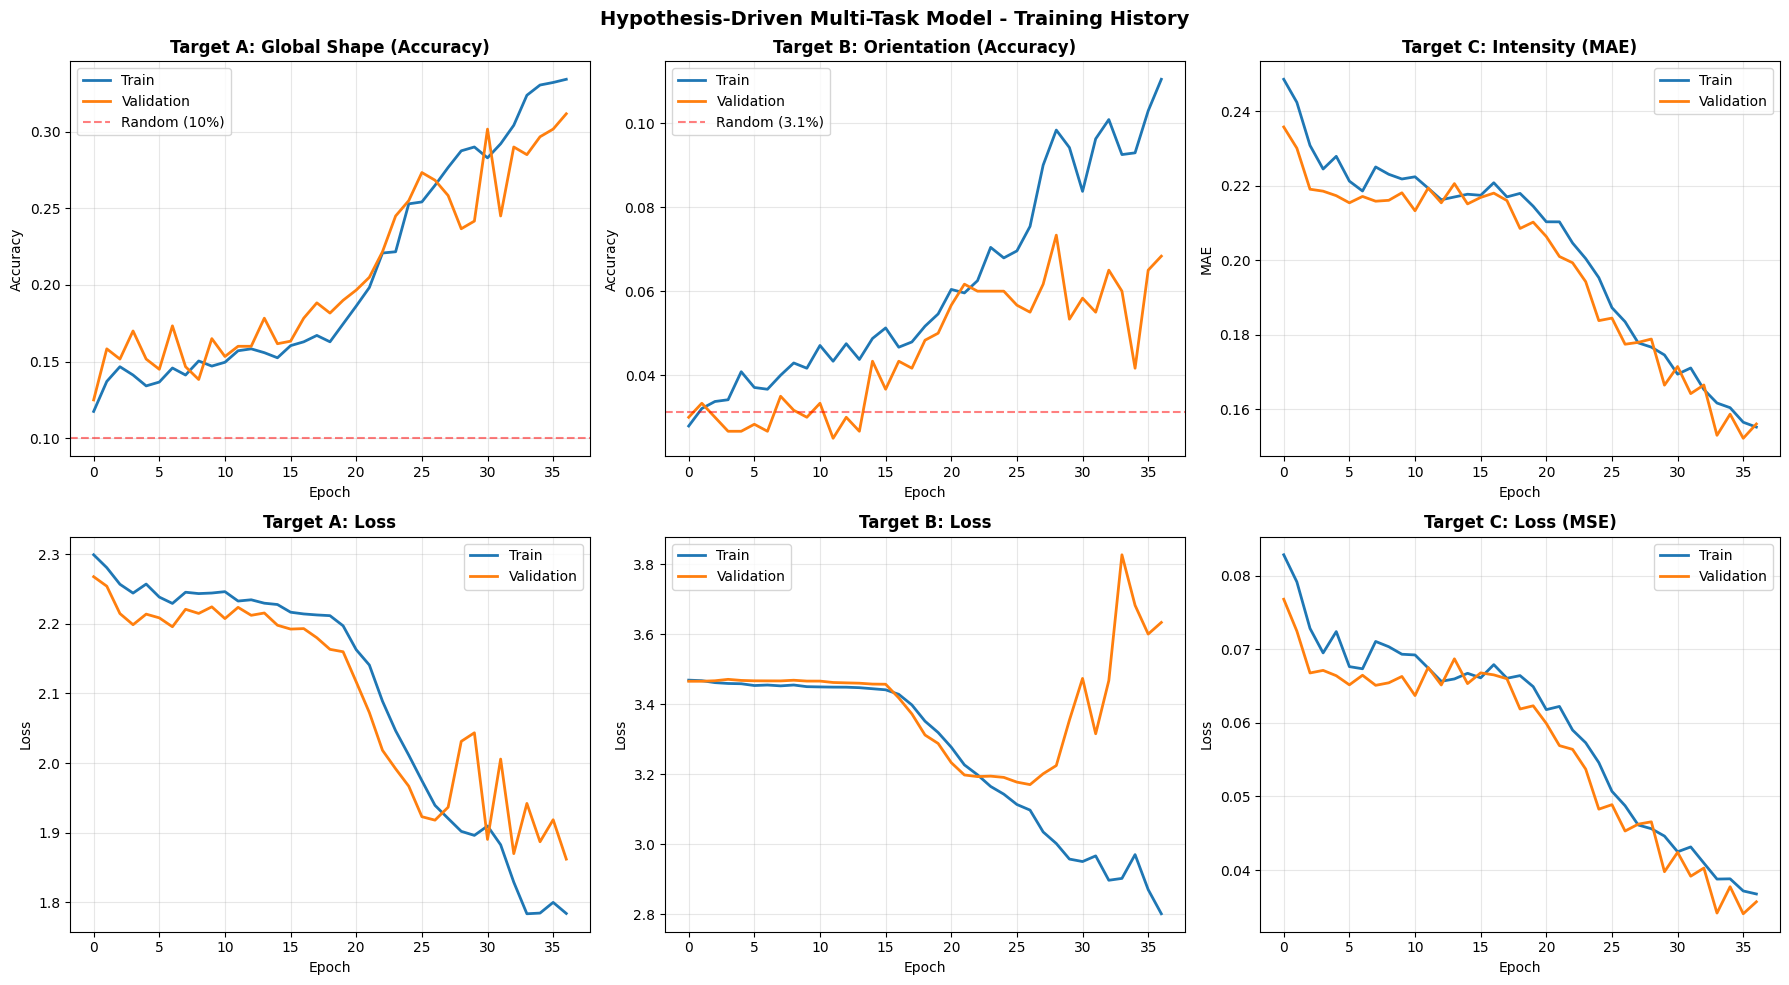


✓ Training completed in 37 epochs
  Best validation - Target A: 31.17%
  Best validation - Target B: 7.33%
  Best validation - Target C: 0.1522 MAE


In [205]:
# Plot training history for MTL model
def plot():
  fig, axes = plt.subplots(2, 3, figsize=(18, 10))
  fig.suptitle('Hypothesis-Driven Multi-Task Model - Training History', fontsize=14, fontweight='bold')

  # Target A - Accuracy
  axes[0, 0].plot(history_mtl.history['output_A_accuracy'], label='Train', linewidth=2)
  axes[0, 0].plot(history_mtl.history['val_output_A_accuracy'], label='Validation', linewidth=2)
  axes[0, 0].axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Random (10%)')
  axes[0, 0].set_title('Target A: Global Shape (Accuracy)', fontweight='bold')
  axes[0, 0].set_xlabel('Epoch')
  axes[0, 0].set_ylabel('Accuracy')
  axes[0, 0].legend()
  axes[0, 0].grid(True, alpha=0.3)

  # Target A - Loss
  axes[1, 0].plot(history_mtl.history['output_A_loss'], label='Train', linewidth=2)
  axes[1, 0].plot(history_mtl.history['val_output_A_loss'], label='Validation', linewidth=2)
  axes[1, 0].set_title('Target A: Loss', fontweight='bold')
  axes[1, 0].set_xlabel('Epoch')
  axes[1, 0].set_ylabel('Loss')
  axes[1, 0].legend()
  axes[1, 0].grid(True, alpha=0.3)

  # Target B - Accuracy
  axes[0, 1].plot(history_mtl.history['output_B_accuracy'], label='Train', linewidth=2)
  axes[0, 1].plot(history_mtl.history['val_output_B_accuracy'], label='Validation', linewidth=2)
  axes[0, 1].axhline(y=1/32, color='r', linestyle='--', alpha=0.5, label='Random (3.1%)')
  axes[0, 1].set_title('Target B: Orientation (Accuracy)', fontweight='bold')
  axes[0, 1].set_xlabel('Epoch')
  axes[0, 1].set_ylabel('Accuracy')
  axes[0, 1].legend()
  axes[0, 1].grid(True, alpha=0.3)

  # Target B - Loss
  axes[1, 1].plot(history_mtl.history['output_B_loss'], label='Train', linewidth=2)
  axes[1, 1].plot(history_mtl.history['val_output_B_loss'], label='Validation', linewidth=2)
  axes[1, 1].set_title('Target B: Loss', fontweight='bold')
  axes[1, 1].set_xlabel('Epoch')
  axes[1, 1].set_ylabel('Loss')
  axes[1, 1].legend()
  axes[1, 1].grid(True, alpha=0.3)

  # Target C - MAE
  axes[0, 2].plot(history_mtl.history['output_C_mae'], label='Train', linewidth=2)
  axes[0, 2].plot(history_mtl.history['val_output_C_mae'], label='Validation', linewidth=2)
  axes[0, 2].set_title('Target C: Intensity (MAE)', fontweight='bold')
  axes[0, 2].set_xlabel('Epoch')
  axes[0, 2].set_ylabel('MAE')
  axes[0, 2].legend()
  axes[0, 2].grid(True, alpha=0.3)

  # Target C - Loss (MSE)
  axes[1, 2].plot(history_mtl.history['output_C_loss'], label='Train', linewidth=2)
  axes[1, 2].plot(history_mtl.history['val_output_C_loss'], label='Validation', linewidth=2)
  axes[1, 2].set_title('Target C: Loss (MSE)', fontweight='bold')
  axes[1, 2].set_xlabel('Epoch')
  axes[1, 2].set_ylabel('Loss')
  axes[1, 2].legend()
  axes[1, 2].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

  print(f"\n✓ Training completed in {len(history_mtl.history['loss'])} epochs")
  print(f"  Best validation - Target A: {max(history_mtl.history['val_output_A_accuracy'])*100:.2f}%")
  print(f"  Best validation - Target B: {max(history_mtl.history['val_output_B_accuracy'])*100:.2f}%")
  print(f"  Best validation - Target C: {min(history_mtl.history['val_output_C_mae']):.4f} MAE")

plot()

In [206]:
import numpy as np
import pandas as pd


y_pred_A_labels = np.argmax(y_pred_A, axis=1)
y_pred_B_labels = np.argmax(y_pred_B, axis=1)
# Softmax confidence for predicted class
conf_B = np.max(y_pred_B, axis=1)

df_B = pd.DataFrame({
    "index": np.arange(len(y_B_val)),
    "B_true": y_B_val,
    "B_pred": y_pred_B_labels,
    "confidence": conf_B,
    "correct": y_pred_B_labels == y_B_val
})

df_B.head()



,index,B_true,B_pred,confidence,correct
0,0,24.0,3,0.094411,False
1,1,5.0,26,0.090460,False
2,2,14.0,13,0.110388,False
3,3,5.0,8,0.074670,False
4,4,12.0,13,0.111254,False


In [207]:
outliers_confident_wrong = df_B[
    (~df_B["correct"]) & (df_B["confidence"] > 0.8)
].sort_values("confidence", ascending=False)

outliers_confident_wrong.head(20)

,index,B_true,B_pred,confidence,correct


In [208]:
low_confidence = df_B.sort_values("confidence").head(20)
low_confidence


,index,B_true,B_pred,confidence,correct
126,126,2.0,8,0.039310,False
73,73,2.0,3,0.039878,False
365,365,21.0,3,0.040881,False
72,72,8.0,8,0.041160,True
146,146,0.0,17,0.041988,False
303,303,28.0,3,0.042314,False
256,256,4.0,10,0.042977,False
141,141,9.0,17,0.043733,False
361,361,20.0,8,0.043908,False
495,495,13.0,13,0.044111,True


In [209]:
unique, counts = np.unique(y_B_train, return_counts=True)
pd.DataFrame({
    "class": unique,
    "count": counts,
    "ratio": counts / counts.sum()
}).sort_values("count")


,class,count,ratio
6,6.0,62,0.025833
2,2.0,63,0.026250
29,29.0,64,0.026667
14,14.0,65,0.027083
10,10.0,65,0.027083
15,15.0,69,0.028750
4,4.0,70,0.029167
21,21.0,70,0.029167
11,11.0,71,0.029583
25,25.0,72,0.030000
